In [143]:
# from torch import tensor, int64, permute, argmin, masked_fill, clamp
from torch.nn.functional import one_hot, conv2d
# from numpy import uint8, ones_like, float64, zeros_like
import torch
import numpy as np
from cv2 import distanceTransform, DIST_L2, DIST_MASK_PRECISE

In [144]:
import matplotlib.pyplot as plt

In [145]:
nclasses = 18
walls_classes = [1, 4]

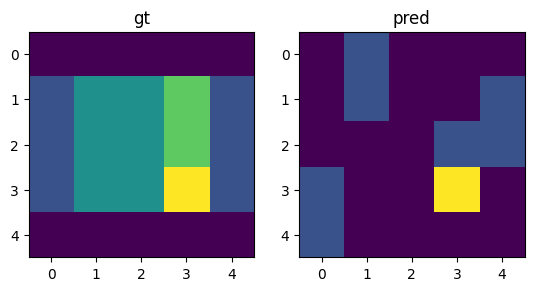

In [146]:
gt = torch.tensor([[0,0,0,0,0],[1,2,2,3,1],[1,2,2,3,1],[1,2,2,4,1],[0,0,0,0,0],], dtype=torch.int64)
pred = torch.tensor([[0,1,0,0,0],[0,1,0,0,1],[0,0,0,1,1],[1,0,0,4,0],[1,0,0,0,0],], dtype=torch.int64)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(gt.numpy())
plt.title('gt')
plt.subplot(1, 2, 2)
plt.imshow(pred.numpy())
plt.title('pred')
plt.show()

In [147]:
gt_cmaps = one_hot(gt, nclasses).permute(2, 0, 1)
pred_cmaps = one_hot(pred, nclasses).permute(2, 0, 1)

In [148]:
# We assume that the model can perfectly separate what's inside the billboard from what's outside, so we assume the pixels labelled
# as 'outside billboard' are walls, i.e. they are pixels to be re-labelled 'Goal net', 'player', ... inside billboard classes.
# Only the pixels labelled in pred as 'outside billboard' but are actually inside the billboard are to be re-labelled (if they are not isolated components, see later)
wallsMask = gt_cmaps[0].clone()
for wall_class in walls_classes:
    wallsMask.add_(pred_cmaps[wall_class])
faulty_inside_billboard = wallsMask > 1  # pred pixels labelled as 'inside billboard' but are actually 'ouside billboard'
print(faulty_inside_billboard)
wallsMask = wallsMask > 0
wallsMask

tensor([[False,  True, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [ True, False, False, False, False]])


tensor([[ True,  True,  True,  True,  True],
        [False,  True, False, False,  True],
        [False, False, False,  True,  True],
        [ True, False, False,  True, False],
        [ True,  True,  True,  True,  True]])

Maybe improve the code below by using torch.tensor.masked_scatter_() ? Maybe 2 times ?

In [149]:
predac_cmaps = gt_cmaps  # predac is the final result with the unlabelled pixels labeled as the nearest class
# No need to clone gt_cmaps, since we will not use it anymore
predac_cmaps[0].masked_fill_(faulty_inside_billboard, 0)
for i in range(1, nclasses):
    if i in walls_classes:
        predac_cmaps[i] = pred_cmaps[i]
    else:
        predac_cmaps[i].masked_fill_(wallsMask, 0)
predac_cmaps

tensor([[[1, 0, 1, 1, 1],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 1, 1, 1, 1]],

        [[0, 1, 0, 0, 0],
         [0, 1, 0, 0, 1],
         [0, 0, 0, 1, 1],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 1, 1, 0, 0],
         [0, 1, 1, 0, 0],
         [0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]

In [150]:
predac_cmaps.permute(1, 2, 0).sum(dim=2)  # If value > 1 = maybe problem. if value == 0 = inside billboard pixels to be re-labelled = OK

tensor([[1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1],
        [0, 1, 1, 1, 1],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1]])

In [151]:
unlabelled_pixels_mask = predac_cmaps.permute(1, 2, 0).sum(dim=2) == 0
unlabelled_pixels_mask

tensor([[False, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [False, False, False, False,  True],
        [False, False, False, False, False]])

In [152]:
predac = predac_cmaps.permute(1, 2, 0).argmax(dim=2)
predac

tensor([[0, 1, 0, 0, 0],
        [0, 1, 2, 3, 1],
        [0, 2, 2, 1, 1],
        [1, 2, 2, 4, 0],
        [1, 0, 0, 0, 0]])

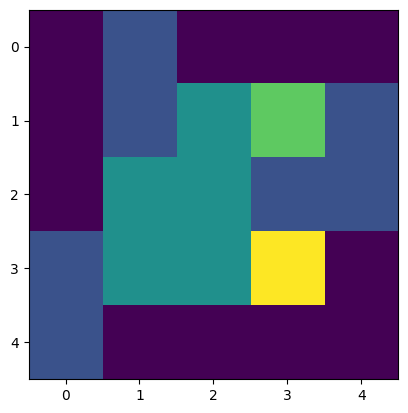

In [153]:
plt.figure()
plt.imshow(predac.numpy())

Remove isolated unlabelled pixels, i.e. pixels that are not in a 4-way component with labelled pixels.

In [154]:
# dil = predac.clamp(0,2)
# dil  # class 0 are the walls, class 1 are the background, class 2 are the dilated pixels

In [155]:
# dil = one_hot(dil, 3).permute(2, 0, 1)
# dil

In [156]:
# # Since we can derive the background class (dil[1]) from the walls and dilated pixels (tensor.ones - dil[0] - dil[2]) , we can remove it
# dil = dil[[0, 2]]
# dil

In [157]:
wallsMask.long()

tensor([[1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1],
        [0, 0, 0, 1, 1],
        [1, 0, 0, 1, 0],
        [1, 1, 1, 1, 1]])

In [158]:
predac.masked_fill(wallsMask, 0).clamp(0, 1)

tensor([[0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0],
        [0, 1, 1, 0, 0],
        [0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0]])

In [159]:
dil = torch.cat((wallsMask.long().unsqueeze(0), predac.masked_fill(wallsMask, 0).clamp(0, 1).unsqueeze(0)), dim=0)
dil

tensor([[[1, 1, 1, 1, 1],
         [0, 1, 0, 0, 1],
         [0, 0, 0, 1, 1],
         [1, 0, 0, 1, 0],
         [1, 1, 1, 1, 1]],

        [[0, 0, 0, 0, 0],
         [0, 0, 1, 1, 0],
         [0, 1, 1, 0, 0],
         [0, 1, 1, 0, 0],
         [0, 0, 0, 0, 0]]])

In [160]:
kernel = torch.tensor([[[0, 0, 0], 
                        [0, -10, 0], 
                        [0, 0, 0]],
                        
                       [[0, 1, 0], 
                        [1, 1, 1], 
                        [0, 1, 0]]], dtype=torch.int64).unsqueeze(0)

In [161]:
prev_dil = dil.clone()
prev_dil[1,0,0] = 1 - prev_dil[1,0,0]  # To make sure the while loop runs at least once
prev_dil

tensor([[[1, 1, 1, 1, 1],
         [0, 1, 0, 0, 1],
         [0, 0, 0, 1, 1],
         [1, 0, 0, 1, 0],
         [1, 1, 1, 1, 1]],

        [[1, 0, 0, 0, 0],
         [0, 0, 1, 1, 0],
         [0, 1, 1, 0, 0],
         [0, 1, 1, 0, 0],
         [0, 0, 0, 0, 0]]])

In [162]:
while not torch.equal(dil, prev_dil):
    prev_dil[1] = dil[1].clone()
    dil[1] = conv2d(dil, kernel, padding='same').clamp(0, 1).squeeze(0)

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]])
tensor([[[1, 1, 1, 1, 1],
         [0, 1, 0, 0, 1],
         [0, 0, 0, 1, 1],
         [1, 0, 0, 1, 0],
         [1, 1, 1, 1, 1]],

        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0],
         [1, 0, 1, 1, 0],
         [1, 1, 1, 0, 0],
         [0, 1, 1, 0, 0],
         [0, 0, 0, 0, 0]]])


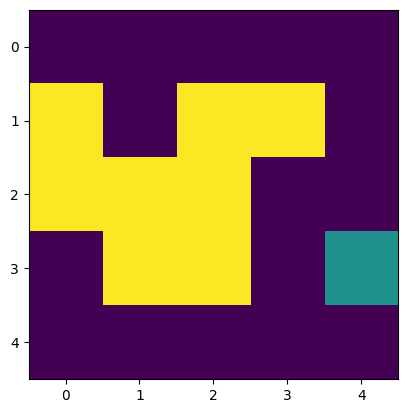

In [163]:
# prev_dil[1] = conv2d(dil, kernel, padding='same').clamp(0,1)[0]
# print(prev_dil)
isolated_pixels = torch.ones_like(prev_dil[1]) - prev_dil[0] - prev_dil[1]
print(isolated_pixels)  # Those background pixels are only connected to the walls, so we can consider them as walls too and remove them from the background
# prev_dil has shape (2, 5, 5), make it to (3, 5 , 5) by adding the background class between the walls and dilated pixels
prev_dil = torch.cat((prev_dil[0].unsqueeze(0), isolated_pixels.unsqueeze(0), prev_dil[1].unsqueeze(0)), dim=0)
print(prev_dil)
rslt = prev_dil.permute(1, 2, 0).argmax(dim=2)
plt.figure()
plt.imshow(rslt.numpy())

Need to add "isolated_pixels" to the walls mask and remove it from the unlabelled_pixels_mask

In [164]:
isolated_pixels_mask = isolated_pixels.bool()
isolated_pixels_mask

tensor([[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False,  True],
        [False, False, False, False, False]])

In [165]:
print(wallsMask)
wallsMask.logical_or_(isolated_pixels_mask)
wallsMask

tensor([[ True,  True,  True,  True,  True],
        [False,  True, False, False,  True],
        [False, False, False,  True,  True],
        [ True, False, False,  True, False],
        [ True,  True,  True,  True,  True]])


tensor([[ True,  True,  True,  True,  True],
        [False,  True, False, False,  True],
        [False, False, False,  True,  True],
        [ True, False, False,  True,  True],
        [ True,  True,  True,  True,  True]])

In [166]:
print(unlabelled_pixels_mask)
unlabelled_pixels_mask.logical_xor_(isolated_pixels_mask)
unlabelled_pixels_mask

tensor([[False, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [False, False, False, False,  True],
        [False, False, False, False, False]])


tensor([[False, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]])

tensor([[2, 1, 2,  ..., 0, 1, 2],
        [2, 0, 1,  ..., 2, 1, 1],
        [1, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 1,  ..., 0, 0, 1],
        [1, 1, 0,  ..., 0, 0, 2],
        [0, 0, 2,  ..., 2, 1, 1]])
8.468373376999807e-05


Text(0.5, 1.0, 'rslt')

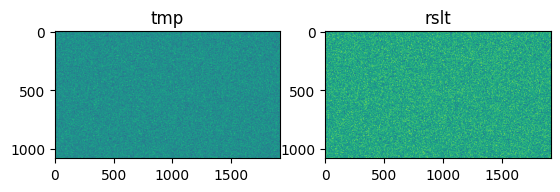

In [128]:
from timeit import timeit

tmp = torch.randint(3, (1080, 1920), dtype=torch.int64)
print(tmp)
tmp_one_hot = one_hot(tmp, 3).permute(2, 0, 1)[[0, 2]].half().to(device='cuda')
kernel = kernel.half().to(device='cuda')
rslt = conv2d(tmp_one_hot, kernel, padding='same').clamp(0,1)
it = 100000
print(timeit('conv2d(tmp_one_hot, kernel, padding=\'same\').clamp(0,1)', globals=globals(), number=it)/it)
# Plot tmp and rslt side by side
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(tmp.numpy())
plt.title('tmp')
plt.subplot(1, 2, 2)
plt.imshow(rslt[0].cpu().numpy())
plt.title('rslt')

tensor([[0, 2, 0,  ..., 2, 0, 2],
        [0, 0, 2,  ..., 2, 2, 1],
        [1, 0, 2,  ..., 0, 1, 1],
        ...,
        [2, 2, 0,  ..., 2, 2, 1],
        [1, 1, 0,  ..., 2, 2, 0],
        [1, 1, 1,  ..., 2, 2, 0]])
0.001859647818000667


Text(0.5, 1.0, 'rslt')

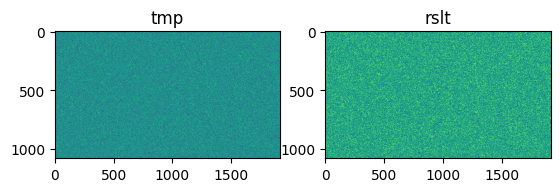

In [127]:
from timeit import timeit

tmp = torch.randint(3, (1080, 1920), dtype=torch.int64)
print(tmp)
tmp_one_hot = one_hot(tmp, 3).permute(2, 0, 1)[[0, 2]].to(torch.int8)
kernel = kernel.to(torch.int8)
rslt = conv2d(tmp_one_hot, kernel, padding='same').clamp(0,1)
it = 1000
print(timeit('conv2d(tmp_one_hot, kernel, padding=\'same\').clamp(0,1)', globals=globals(), number=it)/it)
# Plot tmp and rslt side by side
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(tmp.numpy())
plt.title('tmp')
plt.subplot(1, 2, 2)
plt.imshow(rslt[0].numpy())
plt.title('rslt')

Previous work

In [ ]:
fmap = tensor([[1,1,0,0,0],[0,2,0,0,0],[0,3,0,1,0],[0,2,3,3,0],[0,0,0,0,0],], dtype=int64)
print(fmap)

tensor([[1, 1, 0, 0, 0],
        [0, 2, 0, 0, 0],
        [0, 3, 0, 1, 0],
        [0, 2, 3, 3, 0],
        [0, 0, 0, 0, 0]])


In [ ]:
mask = fmap == 1
print(mask)

tensor([[ True,  True, False, False, False],
        [False, False, False, False, False],
        [False, False, False,  True, False],
        [False, False, False, False, False],
        [False, False, False, False, False]])


In [ ]:
classMaps = 1 - one_hot(fmap, nclasses).permute(2,0,1).numpy().astype(uint8)
# Remove "walls" and "unlabelled" pixels
tmp = ones_like(classMaps[0])
classMaps[:2] = tmp
print(classMaps)

[[[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 0 1 1 1]
  [1 1 1 1 1]
  [1 0 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 0 1 1 1]
  [1 1 0 0 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1

In [ ]:
dist = distanceTransform(classMaps[17], DIST_L2, DIST_MASK_PRECISE)
print(dist)

[[1.8446743e+19 1.8446743e+19 1.8446743e+19 1.8446743e+19 1.8446743e+19]
 [1.8446743e+19 1.8446743e+19 1.8446743e+19 1.8446743e+19 1.8446743e+19]
 [1.8446743e+19 1.8446743e+19 1.8446743e+19 1.8446743e+19 1.8446743e+19]
 [1.8446743e+19 1.8446743e+19 1.8446743e+19 1.8446743e+19 1.8446743e+19]
 [1.8446743e+19 1.8446743e+19 1.8446743e+19 1.8446743e+19 1.8446743e+19]]


In [113]:
# Test
from timeit import timeit
it = 1000
print(timeit('distanceTransform(np.ones((1080,1920), dtype=np.uint8), DIST_L2, DIST_MASK_PRECISE)', globals=globals(), number=it)/it)
# Create a float32 numpy array whose values are +infinites
tmp = np.ones((1080,1920), dtype=np.float32)
tmp.fill(np.inf)
print(tmp)
# timeit
it = 10000
timeit('np.ones((1080,1920), dtype=np.float32).fill(np.inf)', globals=globals(), number=it)/it  # 10 times faster

0.0019491515869995055
[[inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 ...
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]]


0.00024304342880004698

In [ ]:
print(classMaps)
print("next")
dists = zeros_like(classMaps, dtype=float64)
for c in range(0, nclasses):
    dists[c] = distanceTransform(classMaps[c], DIST_L2, DIST_MASK_PRECISE)

[[[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 0 1 1 1]
  [1 1 1 1 1]
  [1 0 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 0 1 1 1]
  [1 1 0 0 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1

In [ ]:
print(dists)

[[[1.84467430e+19 1.84467430e+19 1.84467430e+19 1.84467430e+19
   1.84467430e+19]
  [1.84467430e+19 1.84467430e+19 1.84467430e+19 1.84467430e+19
   1.84467430e+19]
  [1.84467430e+19 1.84467430e+19 1.84467430e+19 1.84467430e+19
   1.84467430e+19]
  [1.84467430e+19 1.84467430e+19 1.84467430e+19 1.84467430e+19
   1.84467430e+19]
  [1.84467430e+19 1.84467430e+19 1.84467430e+19 1.84467430e+19
   1.84467430e+19]]

 [[1.84467430e+19 1.84467430e+19 1.84467430e+19 1.84467430e+19
   1.84467430e+19]
  [1.84467430e+19 1.84467430e+19 1.84467430e+19 1.84467430e+19
   1.84467430e+19]
  [1.84467430e+19 1.84467430e+19 1.84467430e+19 1.84467430e+19
   1.84467430e+19]
  [1.84467430e+19 1.84467430e+19 1.84467430e+19 1.84467430e+19
   1.84467430e+19]
  [1.84467430e+19 1.84467430e+19 1.84467430e+19 1.84467430e+19
   1.84467430e+19]]

 [[1.41421354e+00 1.00000000e+00 1.41421354e+00 2.23606801e+00
   3.16227770e+00]
  [1.00000000e+00 0.00000000e+00 1.00000000e+00 2.00000000e+00
   3.00000000e+00]
  [1.4142135

In [ ]:
dists.shape

(18, 5, 5)

In [ ]:
dists = permute(tensor(dists), (1,2,0))
dists.shape

torch.Size([5, 5, 18])

In [ ]:
dists

tensor([[[1.8447e+19, 1.8447e+19, 1.4142e+00, 2.2361e+00, 1.8447e+19,
          1.8447e+19, 1.8447e+19, 1.8447e+19, 1.8447e+19, 1.8447e+19,
          1.8447e+19, 1.8447e+19, 1.8447e+19, 1.8447e+19, 1.8447e+19,
          1.8447e+19, 1.8447e+19, 1.8447e+19],
         [1.8447e+19, 1.8447e+19, 1.0000e+00, 2.0000e+00, 1.8447e+19,
          1.8447e+19, 1.8447e+19, 1.8447e+19, 1.8447e+19, 1.8447e+19,
          1.8447e+19, 1.8447e+19, 1.8447e+19, 1.8447e+19, 1.8447e+19,
          1.8447e+19, 1.8447e+19, 1.8447e+19],
         [1.8447e+19, 1.8447e+19, 1.4142e+00, 2.2361e+00, 1.8447e+19,
          1.8447e+19, 1.8447e+19, 1.8447e+19, 1.8447e+19, 1.8447e+19,
          1.8447e+19, 1.8447e+19, 1.8447e+19, 1.8447e+19, 1.8447e+19,
          1.8447e+19, 1.8447e+19, 1.8447e+19],
         [1.8447e+19, 1.8447e+19, 2.2361e+00, 2.8284e+00, 1.8447e+19,
          1.8447e+19, 1.8447e+19, 1.8447e+19, 1.8447e+19, 1.8447e+19,
          1.8447e+19, 1.8447e+19, 1.8447e+19, 1.8447e+19, 1.8447e+19,
          1.8447e+1

In [ ]:
argmin(tensor(dists), dim=2)

/tmp/ipykernel_310676/3177299073.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  argmin(tensor(dists), dim=2)


tensor([[2, 2, 2, 2, 2],
        [2, 2, 2, 2, 3],
        [3, 3, 3, 3, 3],
        [2, 2, 3, 3, 3],
        [2, 2, 3, 3, 3]])

In [ ]:
result = argmin(tensor(dists), dim=2)
result = masked_fill(result, mask, 0)

/tmp/ipykernel_310676/4242234228.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = argmin(tensor(dists), dim=2)


In [ ]:
import matplotlib.pyplot as plt

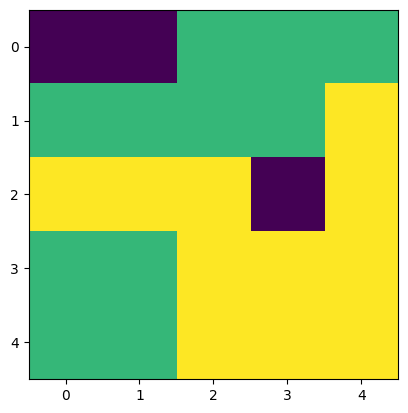

In [ ]:
# Plot the result
plt.imshow(result)

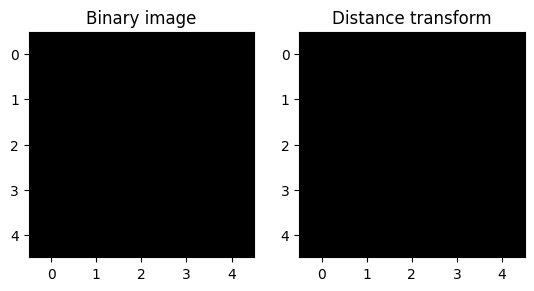

In [ ]:
img = classMaps[17]
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Binary image')
plt.subplot(1, 2, 2)
plt.imshow(dist, cmap='gray')
plt.title('Distance transform')
plt.show()